In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.optimize import lsq_linear

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 500)

In [2]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [3]:
def AR(data_series, p):
    data = pd.DataFrame(data_series.values, columns=["original"])
    if p == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, p+1):
        data[f"lag_{lag}"] = data["original"].shift(lag)

    # first column in data is the y
    y = data.iloc[p:, 0]
    X = data.iloc[p:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_
    print(intercept)
    print(coefs)
    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted
    #data[["original", "predicted"]].plot()
    #plt.show()
    return data
    

In [4]:
def MA(data_series, q):
    data = pd.DataFrame(data_series.values, columns=["error"])
    if q == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, q+1):
        data[f"lag_{lag}"] = data["error"].shift(lag)

    # first column in data is the y
    y = data.iloc[q:, 0]
    X = data.iloc[q:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_

    print(intercept)
    print(coefs)

    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted

    return data

In [219]:
def myARIMA(data_series, p, d, q):
    if d > 1:
        raise Exception("Cannot handle d > 1")
        
    ar_coefs = None
    ma_coefs = None
    data_series = data_series.asfreq('MS')
    
    data = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])

    # difference the series according to parameter d
    data["Diff"] = data["original"]
    for _ in range(d):
        data["Diff"] = data["Diff"].diff()

    mu = data["Diff"].mean()
    # mu = data["original"].mean()
    data["Diff"].fillna(mu)
    
    # set up AR terms with the differenced series
    ar = pd.DataFrame((data["Diff"]).values, index=data.index, columns=["original"])
    if p == 0:
        ar["predicted"] = 0
    else:
        # set up the lags
        shifted = ar["original"].shift(1, freq="infer")
        for lag in range(1, p+1):
            shifted_df = pd.DataFrame(shifted.values, index=shifted.index, columns=[f"lag_{lag}"])
            ar = pd.concat([ar, shifted_df], axis=1)
            shifted = shifted.shift(1)
        ar = ar.fillna(0)

        # get X and y
        X = ar.loc[data.index].iloc[:, 1:]
        y = ar.loc[data.index].iloc[:, 0]

        ar_coefs = lsq_linear(X, y).x
        ar["predicted"] = X.dot(ar_coefs.T)
    
    data["AR_predicted"] = ar["predicted"]

    # Set up MA component with error terms
    ma = pd.DataFrame((ar["original"].loc[data.index] - ar["predicted"].loc[data.index]).values, index=data_series.index, columns=["error"])
    if q == 0:
        ma["predicted"] = 0
    else:
        # set up the lags
        shifted = ma["error"].shift(1, freq="infer")
        for lag in range(1, q+1):
            shifted_df = pd.DataFrame(shifted.values, index=shifted.index, columns=[f"lag_{lag}"])
            ma = pd.concat([ma, shifted_df], axis=1)
            shifted = shifted.shift(1)

        ma = ma.fillna(0)
        # get X and y
        X = ma.loc[data.index].iloc[:, 1:]
        y = ma.loc[data.index].iloc[:, 0]

        ma_coefs = lsq_linear(X, y).x
        ma["predicted"] = X.dot(ma_coefs.T)

    data["MA_predicted"] = ma["predicted"]

    # Put the data back together
    if d == 0:
        data["predicted"] = mu + data["AR_predicted"] + data["MA_predicted"]
    else:
        data["predicted"] = data["original"].shift() + mu + data["AR_predicted"] + data["MA_predicted"]
    data = data.fillna(0)
    # data = data.fillna(data.iloc[-1]["predicted"])

    # new dataframe for forecasts
    forecast = pd.DataFrame()
    forecast["original"] = data["original"]
    forecast["full_data"] = data["original"]
    forecast["predicted"] = data["predicted"]
    forecast["residuals"] = ma["error"]
    forecast["forecast"] = np.NaN

    # forecast 15 timesteps ahead
    for i in range(15):
        ar_forecast = 0
        if p > 0:
            if d == 0:
                for i in range(1, p+1):
                    ar_forecast = ar_coefs[i-1] * forecast.iloc[-i]["full_data"]
            else:
                first_ar = (1 + ar_coefs[0]) * forecast.iloc[-1]["full_data"]
                middle_ar = 0
                for lag in range(1, p):
                    middle_ar += (ar_coefs[lag] - ar_coefs[lag-1]) * forecast.iloc[-lag-1]["full_data"]
                last_ar = ar_coefs[-1] * forecast.iloc[-p-1]["full_data"]
                ar_forecast = first_ar + middle_ar - last_ar
        else:
            if d == 0:
                ar_forecast = 0
            else:
                ar_forecast = forecast.iloc[-1]["full_data"]
        # print(first_ar, middle_ar, last_ar)
        ma_forecast = 0
        if q > 0:
            for i in range(len(ma_coefs)):
                ma_forecast += ma_coefs[i] * forecast.iloc[-i-1]["residuals"]
                
        prediction = mu + ar_forecast + ma_forecast
        # prediction = ar_forecast + ma_forecast
        next_time = forecast.index[-1] + forecast.index.freq
        forecast.loc[next_time] = [np.NaN, prediction, np.NaN, 0, prediction]
        forecast = forecast.asfreq('MS')

    # plot our data
    ar[["original", "predicted"]].plot()
    plt.show()

    ma[["error"]].plot(kind="kde")
    plt.show()

    ma[["error", "predicted"]].plot()
    plt.show()
    
    # forecast[["original", "forecast"]].plot(color=["C0", "green"])
    data[["original", "predicted"]].plot()
    plt.savefig(f"ARIMA_{p}{d}{q}", bbox_inches="tight")
    plt.show()

    return forecast, ar_coefs, ma_coefs, ar, ma, mu



In [6]:
data = pd.read_csv("shampoo.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
first = data.diff()

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -200.182
Date:                Thu, 28 Oct 2021   AIC                            408.364
Time:                        21:57:44   BIC                            414.585
Sample:                    01-01-1901   HQIC                           410.511
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9097      0.242     -3.755      0.000      -1.385      -0.435
ar.L2         -0.2449      0.275     -0.890      0.373      -0.784       0.294
ar.L3          0.0206      0.178      0.116      0.9

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


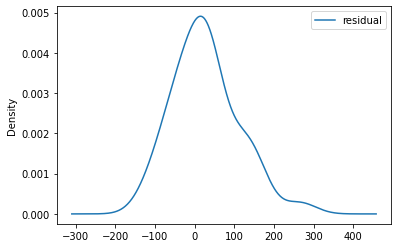

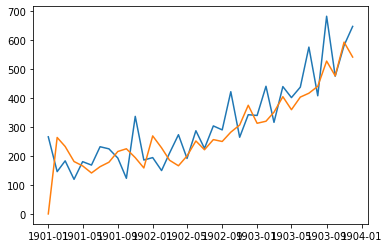

In [112]:
model = ARIMA(data, order=(3,1,0))
# model = ARIMA(first.values, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())
# print(fitted.resid)
pd.DataFrame(fitted.resid, columns=["residual"]).plot(kind="kde")
plt.show()
predicted = fitted.predict(start=0, end=len(data)-1)
# predicted = fitted.predict(start=0, end=len(first)-1)
df = pd.DataFrame()
df["original"] = data.Sales
# df["original"] = first
df["predicted"] = predicted
# df[["original", "predicted"]].plot()
# print("Mean squared error:", mean_squared_error(df["original"], df["predicted"]))
forecast = fitted.forecast(20)
# print(forecast)
plt.plot(df["original"])
plt.plot(df["predicted"])
# plt.plot(forecast)
plt.show()


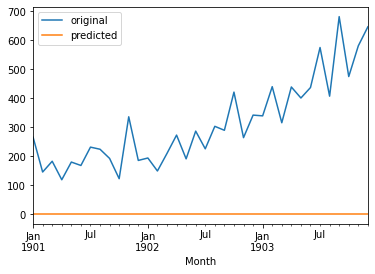

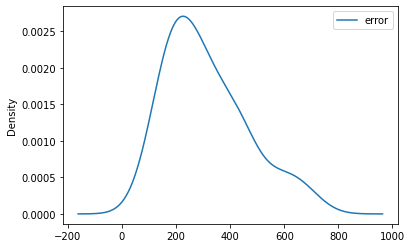

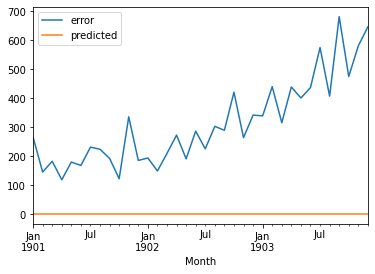

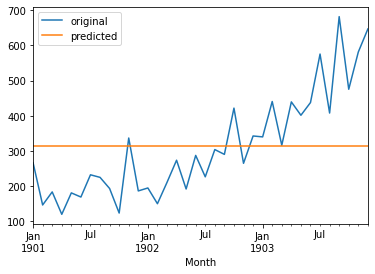

AR coefs: None
MA coefs: None
mu: 312.59999999999997


In [220]:
res, ar_coefs, ma_coefs, ar, ma, mu = myARIMA(data, 0,0,0)
print("AR coefs:", ar_coefs)
print("MA coefs:", ma_coefs)
print("mu:", mu)

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


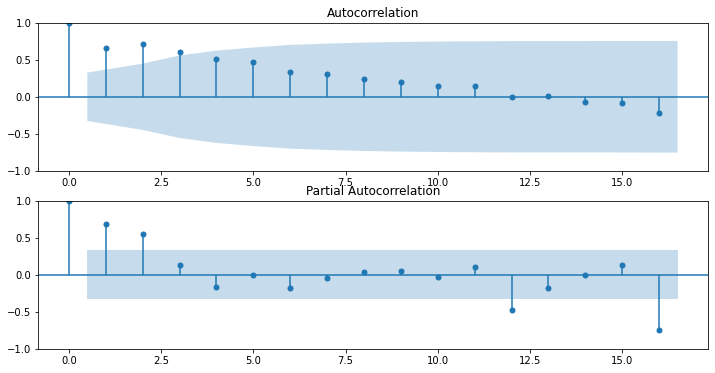

In [214]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(data.dropna(), ax=ax[1], lags=16)
# plt.savefig("acf_pacf_data", bbox_inches="tight")
plt.show()

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


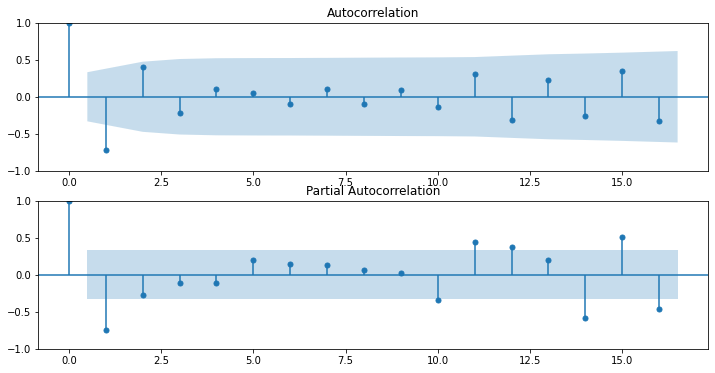

In [213]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(first.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(first.dropna(), ax=ax[1], lags=16)
# plt.savefig("acf_pacf_first", bbox_inches="tight")
plt.show()

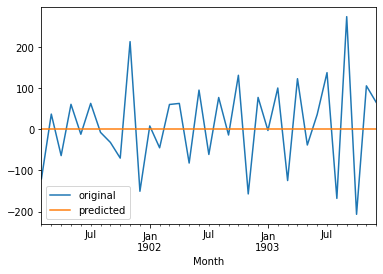

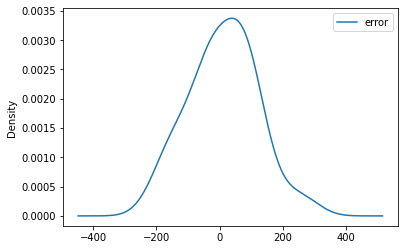

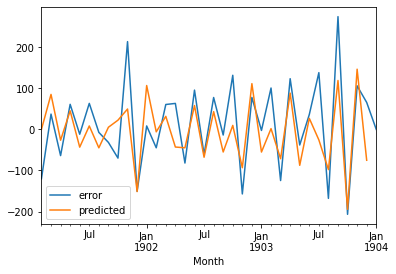

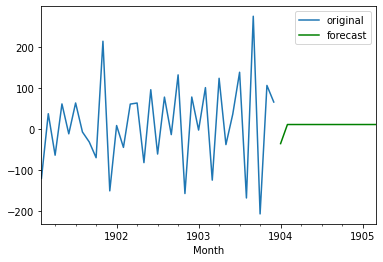

AR coefs: None
MA coefs: [-0.70874876]
mu: 10.882857142857144


In [212]:
res, ar_coefs, ma_coefs, ar, ma, mu = myARIMA(first.dropna(), 0,0,1)
print("AR coefs:", ar_coefs)
print("MA coefs:", ma_coefs)
print("mu:", mu)

In [221]:
from pmdarima import auto_arima

model = auto_arima(data)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -195.731
Date:                Fri, 29 Oct 2021   AIC                            401.463
Time:                        00:23:15   BIC                            409.240
Sample:                             0   HQIC                           404.147
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3051      6.175      1.507      0.132      -2.798      21.408
ar.L1          0.0890      0.314      0.284      0.777      -0.526       0.704
ma.L1         -1.3867      0.314     -4.411      0.0